In [1]:
# Install required libraries
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.9 MB/s eta 0:00:00


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import re
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [4]:
# Connect to google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Read data
news_df = pd.read_csv('/content/drive/MyDrive/Data/train.csv')
submit_test = pd.read_csv('/content/drive/MyDrive/Data/test.csv')
submit_label = pd.read_csv('/content/drive/MyDrive/Data/submit.csv')
submit_test['label'] = submit_label.label

In [6]:
#Check train data
news_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [7]:
#Check test data
submit_test.head()

,id,title,author,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1


In [8]:
#Text Word statistics: min.mean, max and interquartile range

text_len = news_df.text.str.split().str.len()
text_len.describe()

count    20761.000000
mean       760.308126
std        869.525988
min          0.000000
25%        269.000000
50%        556.000000
75%       1052.000000
max      24234.000000
Name: text, dtype: float64

In [9]:
#Title statistics 

title_len = news_df.title.str.split().str.len()
title_len.describe()

count    20242.000000
mean        12.420709
std          4.098735
min          1.000000
25%         10.000000
50%         13.000000
75%         15.000000
max         72.000000
Name: title, dtype: float64

In [10]:
# Check the information of the train data
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [11]:
# Check for null values (handled in data cleaning/preprocessing function)
news_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [12]:
# Check records with null values in title column
news_df[news_df["title"].isnull()].head()

,id,title,author,text,label
53,53,NaN,Dairy✓ᵀᴿᵁᴹᴾ,Sounds like he has our president pegged. What ...,1
120,120,NaN,Anonymous,"Same people all the time , i dont know how you...",1
124,124,NaN,SeekSearchDestory,"You know, outside of any morality arguments, i...",1
140,140,NaN,Anonymous,There is a lot more than meets the eye to this...,1
196,196,NaN,Raffie,They got the heater turned up on high.,1


In [13]:
# Check records with null values in author column
news_df[news_df["author"].isnull()].head()

,id,title,author,text,label
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
20,20,News: Hope For The GOP: A Nude Paul Ryan Has J...,NaN,Email \nSince Donald Trump entered the electio...,1
23,23,Massachusetts Cop’s Wife Busted for Pinning Fa...,NaN,Massachusetts Cop’s Wife Busted for Pinning Fa...,1
31,31,Israel is Becoming Pivotal to China’s Mid-East...,NaN,Country: Israel While China is silently playin...,1


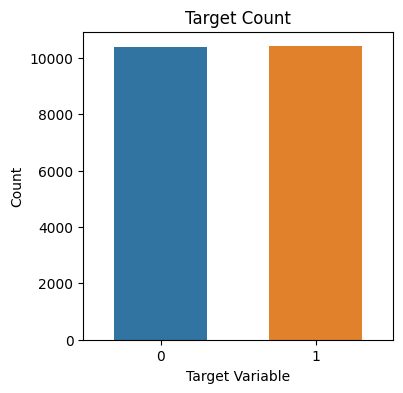

In [14]:
#Countplot for target variable (indicates a balanced dataset)

plt.figure(figsize=(4,4))
sns.countplot(x="label", data=news_df, width=0.6)
plt.title('Target Count', fontsize=12)
plt.xlabel("Target Variable", fontsize = 10)
plt.ylabel("Count", fontsize = 10)

plt.show()

In [16]:
#Download nltk stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
# Define the text cleaning function
def clean_text(text):
    # Remove URLs from the text by replacing them with a space
    text = re.sub(r'http[\w:/\.]+', ' ', text)
    # Remove everything except characters, periods, and whitespace by replacing them with a space
    text = re.sub(r'[^\.\w\s]', ' ', text)
    # Remove non-alphabetic characters by replacing them with a space
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Replace multiple consecutive whitespace characters with a single space
    text = re.sub(r'\s\s+', ' ', text)
    # Convert the text to lowercase and removes leading/trailing whitespace
    text = text.lower().strip()
    return text

# Define the NLTK text preprocessing function
def nltk_preprocessing(text):
    # Checks if text is an instance of a string (excludes null values in text)
    if isinstance(text, str):
        # Call the clean_text() function to clean the text
        text = clean_text(text)
        # Retrieve the stopwords for the English language
        stop_words = set(stopwords.words('english'))
        # Join the words from the cleaned text that are not in the set of stopwords using a space as the separator
        text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply text preprocessing using the nltk_preprocessing() function
news_df['text'] = news_df['text'].apply(nltk_preprocessing).astype(str)
news_df['title'] = news_df['title'].apply(nltk_preprocessing).astype(str)
submit_test['text'] = submit_test['text'].apply(nltk_preprocessing).astype(str)
submit_test['title'] = submit_test['title'].apply(nltk_preprocessing).astype(str)



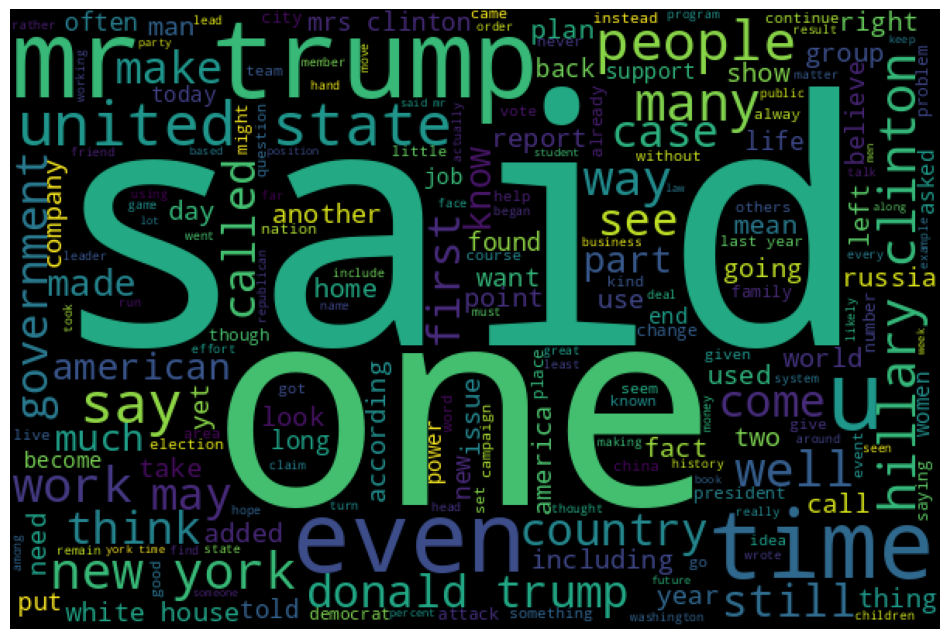

In [18]:
#Word cloud for all word in train data

wordcloud = WordCloud( background_color='black', width=600, height=400)

text_cloud = wordcloud.generate(' '.join(news_df['text']))

plt.figure(figsize=(12,10))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

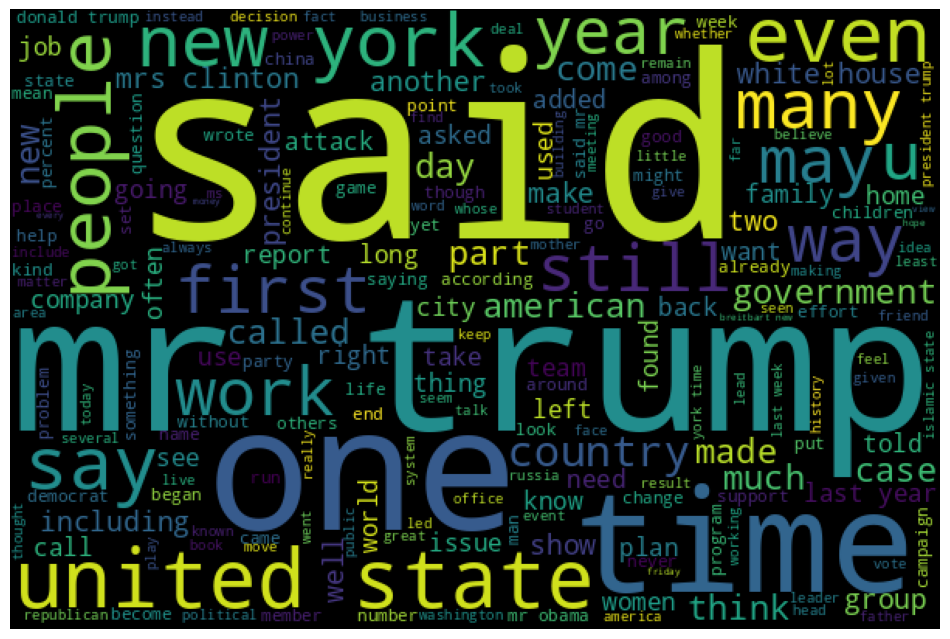

In [19]:
#Word cloud for True label news only

true_news = ' '.join(news_df[news_df['label']==0]['text']) 
wc = wordcloud.generate(true_news)
plt.figure(figsize=(12,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

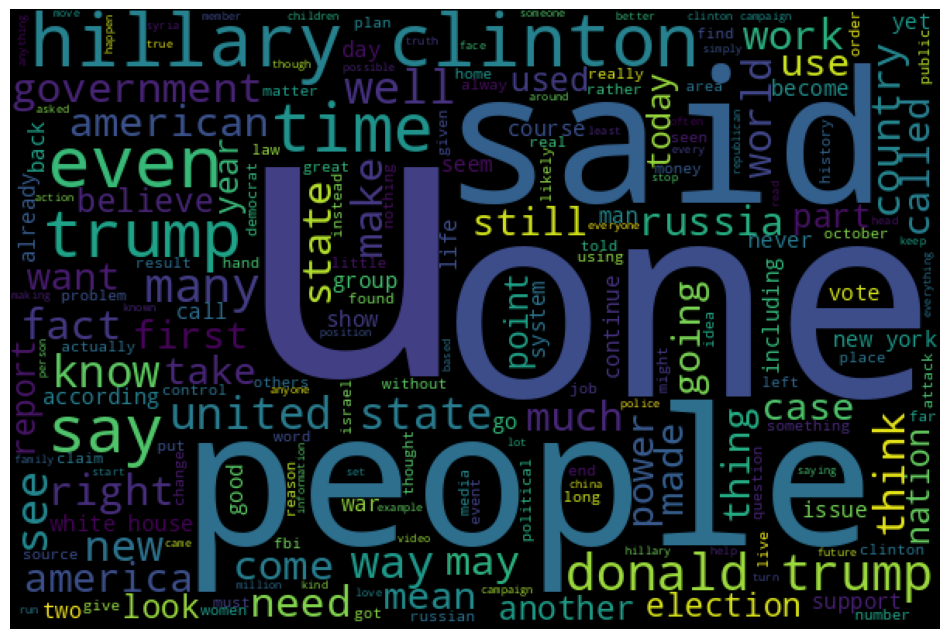

In [20]:
#Word cloud for Fake label news only

fake_news = ' '.join(news_df[news_df['label']==1]['text'])
wc= wordcloud.generate(fake_news)
plt.figure(figsize=(12,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

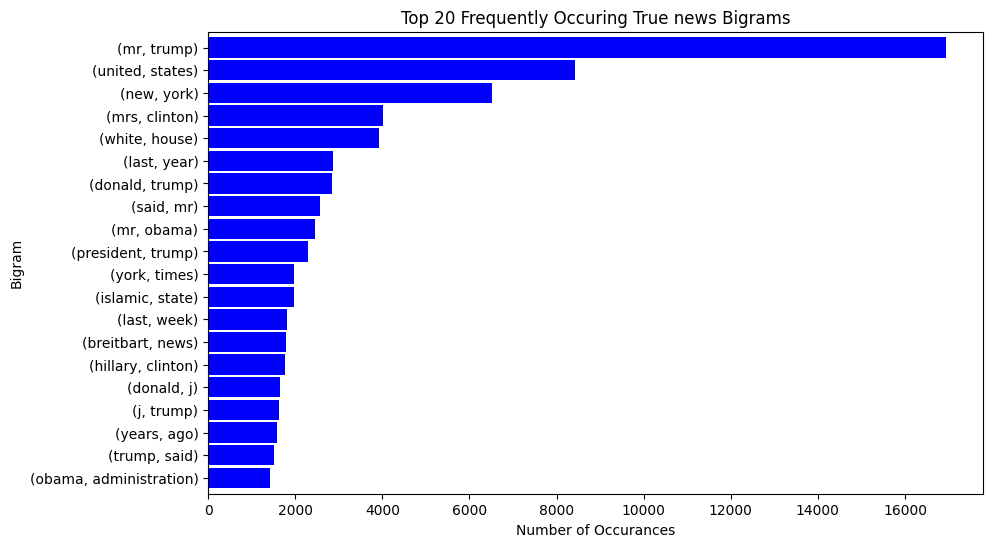

In [21]:
##N-Gram
#Most frequent Bigram(Two word combination) of True label

true_bigrams = (pd.Series(nltk.ngrams(true_news.split(), 2)).value_counts())[:20]
true_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))
plt.title('Top 20 Frequently Occuring True news Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')
plt.show()

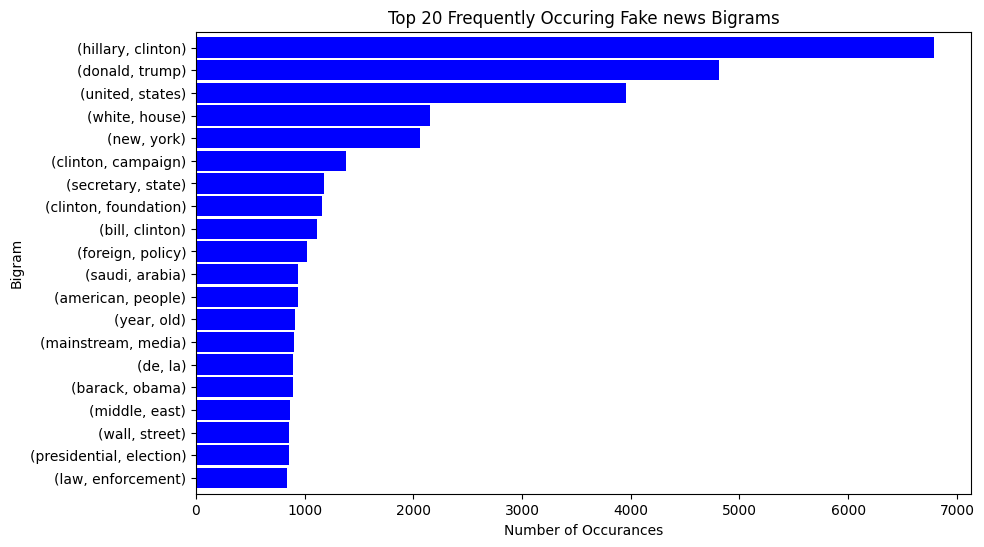

In [22]:
#Most frequent Bigram(Two word combination) of Fake label

fake_bigrams = (pd.Series(nltk.ngrams(fake_news.split(), 2)).value_counts())[:20]
fake_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))
plt.title('Top 20 Frequently Occuring Fake news Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')
plt.show()

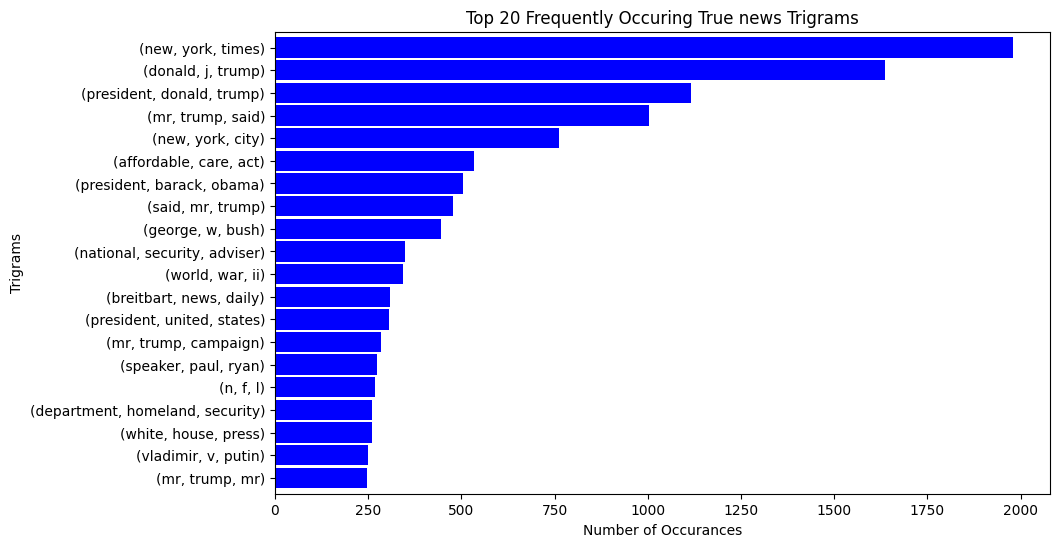

In [23]:
#Most frequent Trigram(Three word combination) of True label

true_bigrams = (pd.Series(nltk.ngrams(true_news.split(), 3)).value_counts())[:20]
true_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))
plt.title('Top 20 Frequently Occuring True news Trigrams')
plt.ylabel('Trigrams')
plt.xlabel('Number of Occurances')
plt.show()

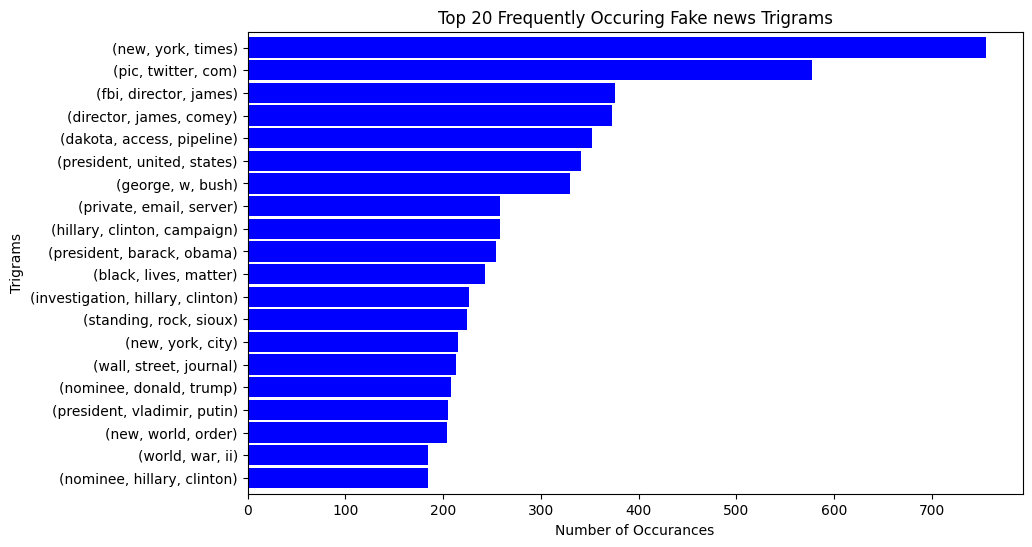

In [24]:
#Most frequent Trigram(Three word combination) of Fake label

fake_bigrams = (pd.Series(nltk.ngrams(fake_news.split(), 3)).value_counts())[:20]
fake_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))
plt.title('Top 20 Frequently Occuring Fake news Trigrams')
plt.ylabel('Trigrams')
plt.xlabel('Number of Occurances')
plt.show()

In [25]:
# Define the BERT-based classification model
class BertClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

# Define a custom dataset class
class NewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.texts = df['title'] + ' ' + df['text']
        self.labels = df['label'].apply(lambda x: 1 if x == 'fake' else 0)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoded_inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoded_inputs['input_ids'].squeeze()
        attention_mask = encoded_inputs['attention_mask'].squeeze()

        return input_ids, attention_mask, label


In [26]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [27]:
# Define the maximum sequence length
max_length = 512

# Create the train and test datasets
train_dataset = NewsDataset(news_df, tokenizer, max_length)
test_dataset = NewsDataset(submit_test, tokenizer, max_length)

In [28]:
# Define the data loaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [29]:
# Initialize the BERT classifier model
num_labels = 2
model = BertClassifier(num_labels)

# Set the BERT model parameters as non-trainable
for param in model.bert.parameters():
    param.requires_grad = False

# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 2
print_frequency = 100  # Print progress every 100 steps
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for step, (input_ids, attention_mask, labels) in enumerate(train_dataloader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        _, predicted_labels = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

        loss.backward()
        optimizer.step()

        # Print progress every print_frequency steps
        if (step + 1) % print_frequency == 0:
            batch_loss = running_loss / print_frequency
            batch_accuracy = correct_predictions / total_predictions
            print(f'Epoch [{epoch+1}/{num_epochs}] | Step [{step+1}/{len(train_dataloader)}] | '
                  f'Training Loss: {batch_loss:.4f} | Training Accuracy: {batch_accuracy:.4f}')

            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_predictions

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training Loss: {epoch_loss:.4f} | Training Accuracy: {epoch_accuracy:.4f}')

    # Evaluation on the test set
    model.eval()
    test_correct_predictions = 0
    test_total_predictions = 0

    with torch.no_grad():
        for input_ids, attention_mask, labels in test_dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            _, predicted_labels = torch.max(outputs, 1)

            test_correct_predictions += (predicted_labels == labels).sum().item()
            test_total_predictions += labels.size(0)

    test_accuracy = test_correct_predictions / test_total_predictions
    print(f'Test Accuracy: {test_accuracy:.4f}')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'model_transformer.pt')



Epoch [1/2] | Step [100/650] | Training Loss: 0.0254 | Training Accuracy: 1.0000
Epoch [1/2] | Step [200/650] | Training Loss: 0.0127 | Training Accuracy: 1.0000
Epoch [1/2] | Step [300/650] | Training Loss: 0.0075 | Training Accuracy: 1.0000
Epoch [1/2] | Step [400/650] | Training Loss: 0.0050 | Training Accuracy: 1.0000
Epoch [1/2] | Step [500/650] | Training Loss: 0.0039 | Training Accuracy: 1.0000
Epoch [1/2] | Step [600/650] | Training Loss: 0.0034 | Training Accuracy: 0.9997
Epoch 1/2
Training Loss: 0.0002 | Training Accuracy: 1.0000
Test Accuracy: 1.0000
Epoch [2/2] | Step [100/650] | Training Loss: 0.0020 | Training Accuracy: 1.0000
Epoch [2/2] | Step [200/650] | Training Loss: 0.0017 | Training Accuracy: 1.0000
Epoch [2/2] | Step [300/650] | Training Loss: 0.0017 | Training Accuracy: 1.0000
Epoch [2/2] | Step [400/650] | Training Loss: 0.0014 | Training Accuracy: 1.0000
Epoch [2/2] | Step [500/650] | Training Loss: 0.0011 | Training Accuracy: 1.0000
Epoch [2/2] | Step [600/650

In [15]:
# Load the best model
model.load_state_dict(torch.load('model_transformer.pt'))

# Prediction and classification report
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask)
        _, predicted_labels = torch.max(outputs, 1)

        y_true.extend(labels.tolist())
        y_pred.extend(predicted_labels.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print('Classification Report:')
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5200

    accuracy                           1.00      5200
   macro avg       1.00      1.00      1.00      5200
weighted avg       1.00      1.00      1.00      5200

